In [1]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt
import itertools
import math
from IPython import display

In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [48]:
# Hyper-parameters
latent_size = 100
hidden_size = 256
image_size = 784
num_epochs = 200
batch_size = 100

In [49]:
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5],   # 1 for greyscale channels
                                     std=[0.5])])

train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True)

test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [50]:
class Discriminator(nn.Module):
    def __init__(self, image_size, hidden_size):
        super(Discriminator, self).__init__()       
        self.model = nn.Sequential(
                        nn.Linear(image_size, hidden_size),
                        nn.LeakyReLU(0.2),
                        nn.Linear(hidden_size, hidden_size),
                        nn.LeakyReLU(0.2),
                        nn.Linear(hidden_size, 1),
                        nn.Sigmoid())
    
    # forward method
    def forward(self, x): 
        out = self.model(x.view(x.size(0), 784))
        out = out.view(out.size(0), -1)
        return out
    
class Generator(nn.Module):
    def __init__(self, image_size, hidden_size, latent_size):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
                        nn.Linear(latent_size, hidden_size),
                        nn.ReLU(),
                        nn.Linear(hidden_size, hidden_size),
                        nn.ReLU(),
                        nn.Linear(hidden_size, image_size),
                        nn.Tanh())
    
    # forward method
    def forward(self, x):
        x = x.view(x.size(0), 100)
        out = self.model(x)
        return out

In [51]:
# Device setting
D = Discriminator(image_size, hidden_size).to(device)
G = Generator(image_size, hidden_size, latent_size).to(device)

In [52]:
# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [53]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

In [54]:
# draw samples from the input distribution to inspect the generation on training 
num_test_samples = 16
test_noise = torch.randn(num_test_samples, latent_size).to(device)

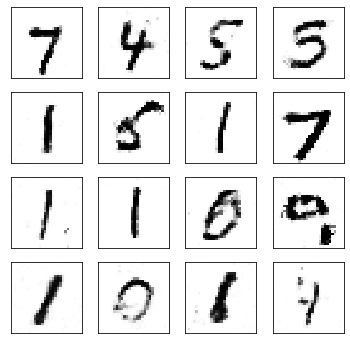

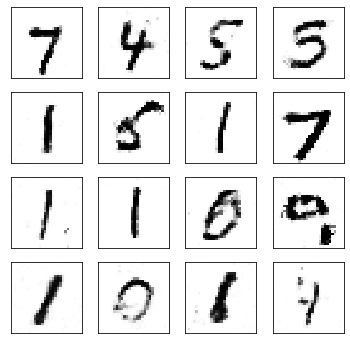

In [58]:
# create figure for plotting
size_figure_grid = int(math.sqrt(num_test_samples))
fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6, 6))
for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False)
    
# Start training
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(train_loader):
        #images = images.view(batch_size, -1).to(device)
        
        # Create the labels which are later used as input for the BCE loss
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #

        # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
        # Second term of the loss is always zero since real_labels == 1
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        
        # Compute BCELoss using fake images
        # First term of the loss is always zero since fake_labels == 0
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # Backprop and optimize
        d_loss = d_loss_real + d_loss_fake
        reset_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # ================================================================== #
        #                        Train the generator                         #
        # ================================================================== #

        # Compute loss with fake images
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        
        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
        g_loss = criterion(outputs, real_labels)
        
        # Backprop and optimize
        reset_grad()
        g_loss.backward()
        g_optimizer.step()
        
        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
            
            test_images = G(test_noise)
            for k in range(num_test_samples):
                i = k//4
                j = k%4
                ax[i,j].cla()
                ax[i,j].imshow(test_images[k,:].data.cpu().numpy().reshape(28, 28), cmap='Greys')
            display.clear_output(wait=True)
            display.display(plt.gcf())